Get dataset from https://github.com/OlafenwaMoses/FireNET
combine train and validate source sets, as these are split in code

To try: [EfficientDet](https://airctic.com/model_efficientdet/)

In [8]:
!wget https://github.com/OlafenwaMoses/FireNET/releases/download/v1.0/fire-dataset.zip -q

In [9]:
!unzip fire-dataset.zip

Archive:  fire-dataset.zip
   creating: fire-dataset/
   creating: fire-dataset/train/
   creating: fire-dataset/train/annotations/
  inflating: fire-dataset/train/annotations/img (100).xml  
  inflating: fire-dataset/train/annotations/img (101).xml  
  inflating: fire-dataset/train/annotations/img (102).xml  
  inflating: fire-dataset/train/annotations/img (103).xml  
  inflating: fire-dataset/train/annotations/img (104).xml  
  inflating: fire-dataset/train/annotations/img (105).xml  
  inflating: fire-dataset/train/annotations/img (106).xml  
  inflating: fire-dataset/train/annotations/img (107).xml  
  inflating: fire-dataset/train/annotations/img (108).xml  
  inflating: fire-dataset/train/annotations/img (109).xml  
  inflating: fire-dataset/train/annotations/img (110).xml  
  inflating: fire-dataset/train/annotations/img (111).xml  
  inflating: fire-dataset/train/annotations/img (112).xml  
  inflating: fire-dataset/train/annotations/img (113).xml  
  inflating: fire-dataset/tr

In [10]:
!rm  fire-dataset.zip

In [11]:
cp fire-dataset/validation/annotations/* fire-dataset/train/annotations/

In [12]:
cp fire-dataset/validation/images/* fire-dataset/train/images/

In [13]:
!rm  -r fire-dataset/validation/

In [14]:
!ls fire-dataset/train

annotations  images


https://airctic.com/getting_started/

In [25]:
!pip install icevision[all] icedata

In [1]:
from icevision.all import *

Following https://airctic.github.io/icedata/dataset_voc_nb/

In [2]:
data_dir = Path('fire-dataset/train')
data_dir

Path('fire-dataset/train')

In [3]:
images_dir = data_dir / 'images'
annotations_dir = data_dir / 'annotations'

In [4]:
image_files = [i for i in images_dir.glob('*')]
image_files[:3]

[Path('fire-dataset/train/images/small (41).jpg'),
 Path('fire-dataset/train/images/pic (103).jpg'),
 Path('fire-dataset/train/images/img (113).jpg')]

In [5]:
annotation_files = [i for i in annotations_dir.glob('*')]
annotation_files[:3]

[Path('fire-dataset/train/annotations/small (26).xml'),
 Path('fire-dataset/train/annotations/small (54).xml'),
 Path('fire-dataset/train/annotations/small (92).xml')]

In [6]:
class_map = ClassMap(['fire'])

In [7]:
parser = parsers.voc(annotations_dir=annotations_dir, images_dir=images_dir, class_map=class_map)

In [8]:
data_splitter = RandomSplitter((.8, .2))
train_records, valid_records = parser.parse(data_splitter)

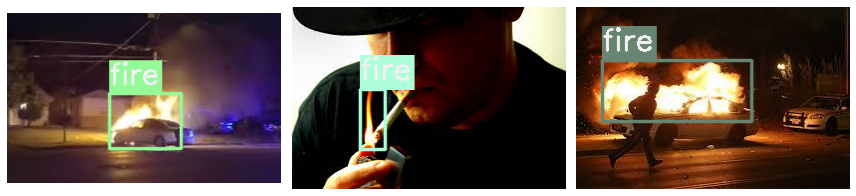

In [9]:
show_records(train_records[:3], ncols=3, class_map=class_map)

In [10]:
presize = 512
size = 384

train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=size), tfms.A.Normalize()])

The Dataset class combines the records and transforms.

In [11]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

Displaying the same image with different transforms

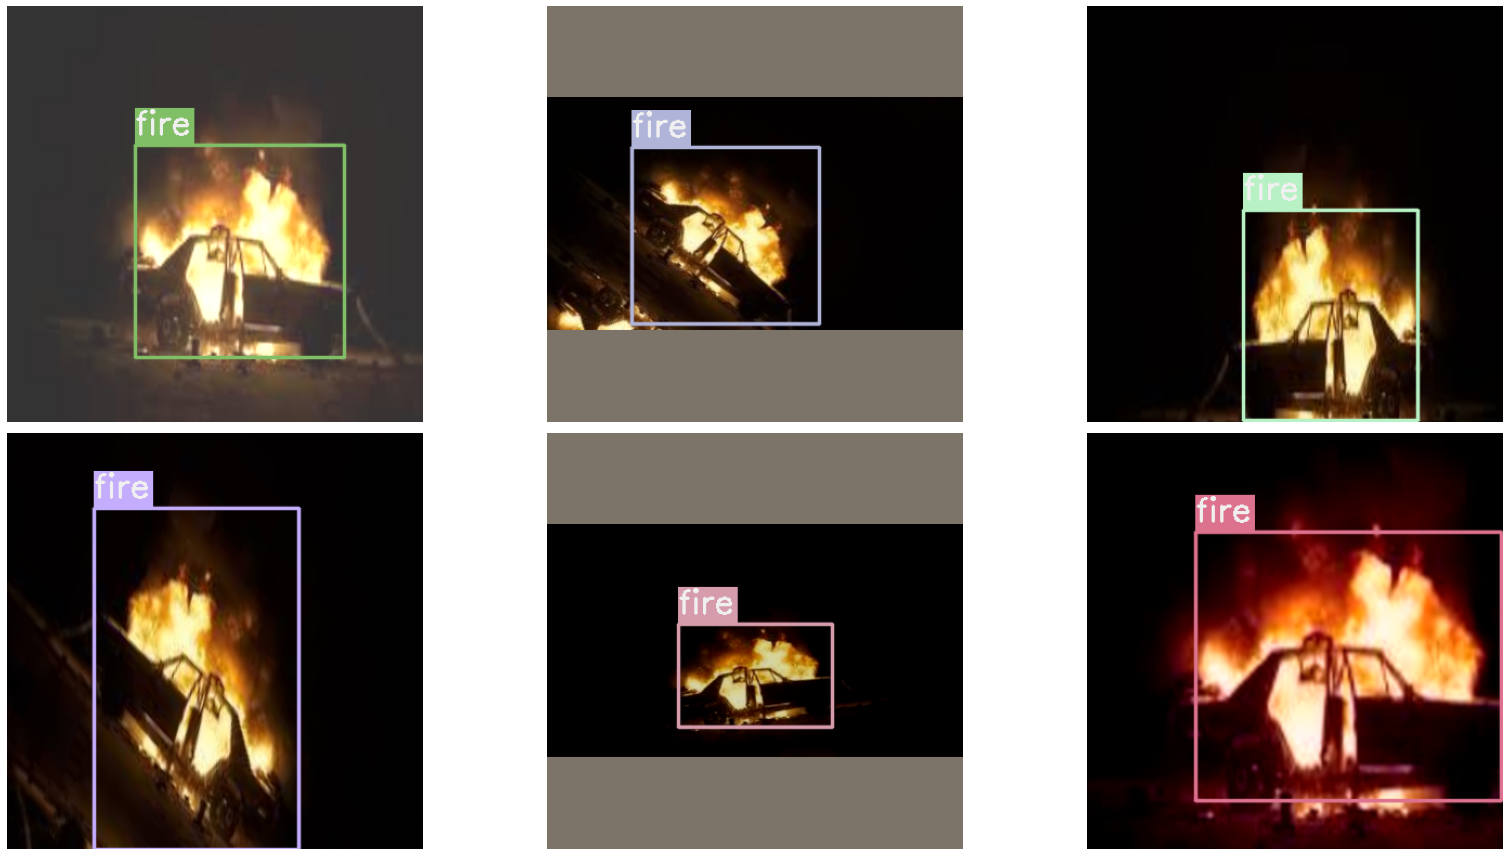

In [12]:
samples = [train_ds[3] for _ in range(6)]
show_samples(samples, ncols=3, class_map=class_map)

The model accepts a variety of backbones. In following example, the tf_efficientdet_lite0 is used. We can also choose one of the efficientdet_d0 to efficientdet_d7 backbones, and MobileNetv3 classes (which also includes MNasNet, MobileNetV2, MixNet and more)

In [13]:
model = efficientdet.model(
    model_name="tf_efficientdet_lite0", num_classes=len(class_map), img_size=size
)

Downloading: "https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_lite0-f5f303a9.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientdet_lite0-f5f303a9.pth


Each model has its own dataloader (a pytorch `DataLoader`) that could be customized: the dataloaders for the RCNN models have a custom collate function.

In [14]:
# DataLoaders
train_dl = efficientdet.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = efficientdet.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)

IceVision is an agnostic framework meaning it can be plugged to multiple DL frameworks such as fastai, and pytorch-lightning. 

Metrics are essential for tracking the model progress as it's training.
Here we are going to be using the well established COCOMetric, which reports on the mean average precision of the predictions.

In [15]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

Creating a fastai compatible Learner using the fastai interface.

When I joined the source training and validation data to get a larger number of images, the learning rate changed considerably

In [16]:
# Fastai Learner
learn = efficientdet.fastai.learner(
    dls=[train_dl, valid_dl], model=model, metrics=metrics
)
learn.fine_tune(10, 1e-2, freeze_epochs=1)

epoch,train_loss,valid_loss,COCOMetric,time
0,166.262711,115.489746,0.000000,00:14


epoch,train_loss,valid_loss,COCOMetric,time
0,1.530216,28.447149,0.000019,00:16
1,1.188667,8.813116,0.008994,00:15
2,1.016768,4.740065,0.030276,00:15
3,0.940772,2.206311,0.040408,00:15
4,0.899905,1.142105,0.143783,00:16
5,0.844140,0.858518,0.182690,00:15
6,0.777157,0.774467,0.221789,00:15
7,0.730491,0.729282,0.233060,00:15
8,0.700799,0.709596,0.247776,00:15
9,0.687243,0.694013,0.240883,00:16


Minimum/10: 2.09e-02, steepest point: 1.74e-01


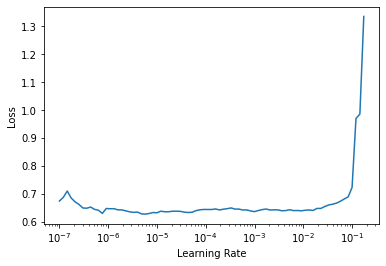

In [17]:
learn.freeze()
lr_min,lr_steep = learn.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

The fastai fine_tune method is useful when you have a pre-trained model, which we are using. It does an initial epoch where it freezes everything except its final layers. It then carries on for the indicated number of epochs using a differential learning rate to train the whole model. It adjusts the learning rate both across the layers of the model as well as across the epochs. This can give excellent results with reduced training time.

Now:
* Phase 1: Train the head for 10 epochs while freezing the body
* Phase 2: Train both the body and the head during 50 epochs

In [18]:
learn.fine_tune(50, 1e-2, freeze_epochs=10)

epoch,train_loss,valid_loss,COCOMetric,time
0,0.618476,0.670965,0.251745,00:14
1,0.646783,0.685895,0.242337,00:14
2,0.654567,0.693076,0.267880,00:14
3,0.661404,0.705919,0.224800,00:14
4,0.674466,0.729893,0.242624,00:14
5,0.683583,0.726823,0.224836,00:14
6,0.692705,0.745605,0.222199,00:14
7,0.684788,0.832636,0.175740,00:14
8,0.690746,0.877804,0.181550,00:14
9,0.717388,0.799010,0.204449,00:14


epoch,train_loss,valid_loss,COCOMetric,time
0,0.639768,0.737758,0.245657,00:15
1,0.631720,0.696852,0.268422,00:15
2,0.620066,0.658377,0.261688,00:15
3,0.635349,0.688352,0.267379,00:15
4,0.618968,0.660255,0.273502,00:15
5,0.622824,0.657913,0.278294,00:16
6,0.623152,0.689440,0.239345,00:15
7,0.629921,0.693990,0.277091,00:15
8,0.613505,0.697191,0.234175,00:15
9,0.602588,0.724256,0.245941,00:16


## Results
* lr of `1e-2` the COCOMetric started to trend upwards after 30 epochs, ending up at `0.324906`?


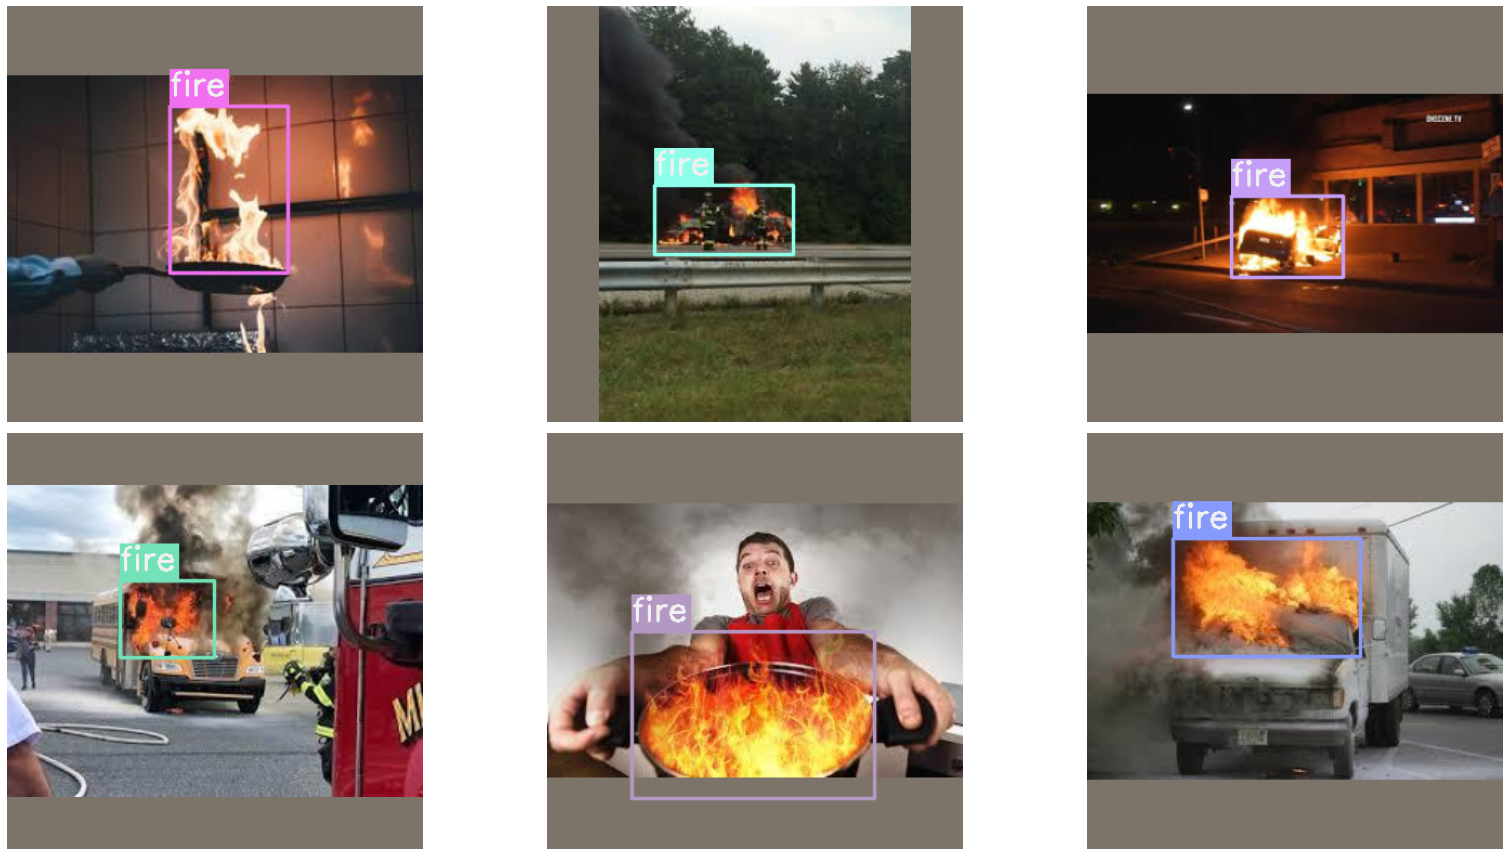

In [19]:
efficientdet.show_results(model, valid_ds, class_map=class_map)

https://airctic.github.io/icedata/how-to/#how-to-save-trained-weights-in-google-colab

In [20]:

## Saving a Model on Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = Path('/content/gdrive/My Drive/')

torch.save(model.state_dict(), root_dir/'models/icedata/efficientdet_fire.pth')

Mounted at /content/gdrive


`"efficientdet_fire.pth" (13MB)`